
# Blood Donation — **Production-Ready ML Pipeline (Final)**
(Loads `/mnt/data/blood.csv`)


In [1]:

import sys, platform, warnings
warnings.filterwarnings("ignore")
print("Python:", sys.version.split()[0])
print("Platform:", platform.platform())
try:
    import numpy as np, pandas as pd, sklearn, matplotlib
    print("NumPy:", np.__version__)
    print("Pandas:", pd.__version__)
    print("Scikit-learn:", sklearn.__version__)
    print("Matplotlib:", matplotlib.__version__)
    try:
        import tensorflow as tf
        print("TensorFlow:", tf.__version__)
    except Exception as e:
        print("TensorFlow not available:", e)
except Exception as e:
    print("Import issue:", e)


Python: 3.12.9
Platform: Windows-11-10.0.26200-SP0
NumPy: 2.0.2
Pandas: 2.2.3
Scikit-learn: 1.5.2
Matplotlib: 3.8.4
TensorFlow: 2.20.0


In [2]:

import os, json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import (train_test_split, RepeatedStratifiedKFold,
                                     RandomizedSearchCV, cross_val_score)
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import (accuracy_score, roc_auc_score, average_precision_score,
                             f1_score, precision_recall_fscore_support, confusion_matrix)
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.inspection import permutation_importance

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier

from sklearn.base import BaseEstimator, TransformerMixin
import joblib

try:
    import tensorflow as tf
    from tensorflow import keras
    from tensorflow.keras import layers
    TF_AVAILABLE = True
except Exception:
    TF_AVAILABLE = False

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
try:
    tf.random.set_seed(RANDOM_STATE)
except Exception:
    pass


In [3]:
DATA_PATH = "C:/Users/aksha/Downloads/blood.csv"
df = pd.read_csv(DATA_PATH)
target_col = "Class" if "Class" in df.columns else df.columns[-1]
y = df[target_col].astype(str)
X = df.drop(columns=[target_col]).copy()

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)
X_valid, X_test, y_valid, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)
print("Target:", target_col, "| Train/Valid/Test:", X_train.shape, X_valid.shape, X_test.shape)


Target: Class | Train/Valid/Test: (561, 4) (93, 4) (94, 4)


In [4]:

def eda_overview(df_all, target_series):
    print("Rows, Cols:", df_all.shape)
    print("\nDtypes:\n", df_all.dtypes)
    miss = df_all.isna().mean().sort_values(ascending=False)
    print("\nMissingness (%):\n", (miss*100).round(2))
    print("\nTarget distribution:\n", target_series.value_counts())
    print("Prevalence (pos='1'):", (target_series=='1').mean())

eda_overview(X, y)


Rows, Cols: (748, 4)

Dtypes:
 Recency      int64
Frequency    int64
Monetary     int64
Time         int64
dtype: object

Missingness (%):
 Recency      0.0
Frequency    0.0
Monetary     0.0
Time         0.0
dtype: float64

Target distribution:
 Class
0    570
1    178
Name: count, dtype: int64
Prevalence (pos='1'): 0.23796791443850268


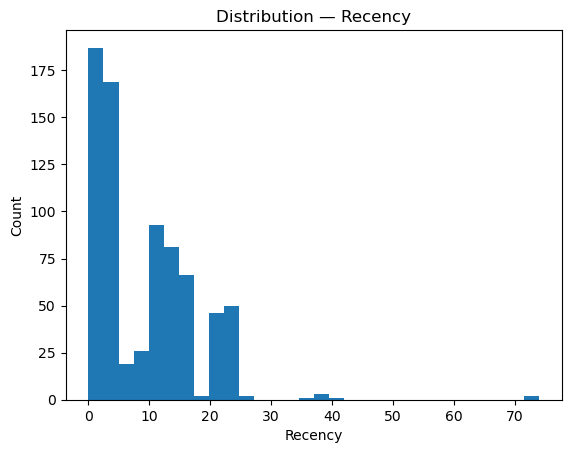

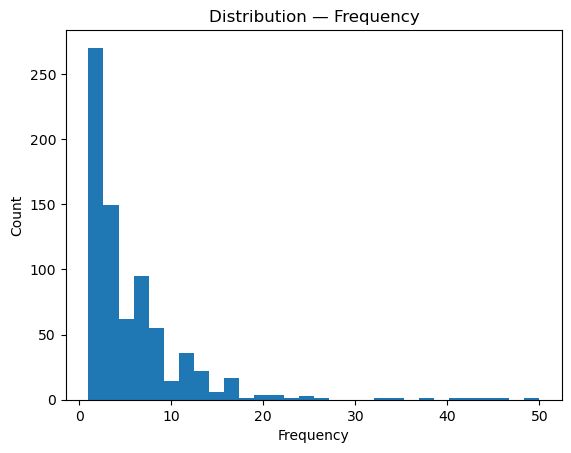

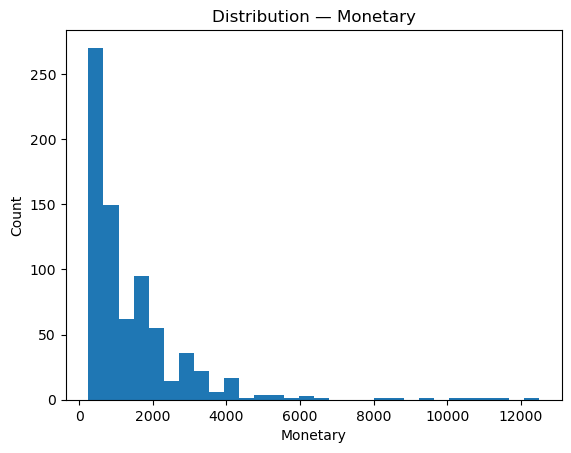

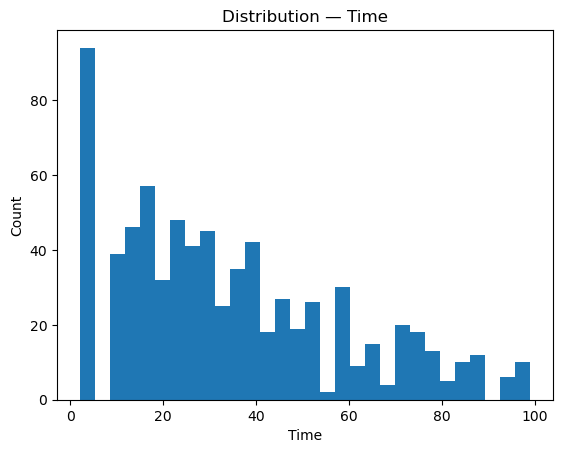

In [5]:

for col in X.columns:
    if pd.api.types.is_numeric_dtype(X[col]):
        plt.figure(); plt.hist(X[col].dropna(), bins=30)
        plt.title(f"Distribution — {col}"); plt.xlabel(col); plt.ylabel("Count"); plt.show()


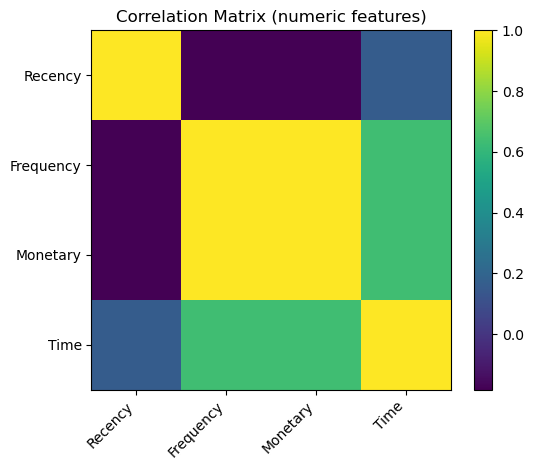

In [6]:

num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
if len(num_cols) >= 2:
    corr = X[num_cols].corr()
    plt.figure()
    im = plt.imshow(corr, interpolation='nearest')
    plt.xticks(range(len(num_cols)), num_cols, rotation=45, ha='right')
    plt.yticks(range(len(num_cols)), num_cols)
    plt.title("Correlation Matrix (numeric features)")
    plt.colorbar(im, fraction=0.046, pad=0.04)
    plt.tight_layout(); plt.show()


In [7]:

class AddBloodFeatures(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None): return self
    def transform(self, X):
        X = X.copy(); eps=1.0
        if 'Monetary' in X and 'Frequency' in X:
            X['avg_cc_per_donation'] = X['Monetary']/np.maximum(X['Frequency'], eps)
        if 'Frequency' in X and 'Time' in X:
            X['donation_rate'] = X['Frequency']/np.maximum(X['Time'], eps)
        if 'Recency' in X and 'Time' in X:
            X['recency_ratio'] = X['Recency']/np.maximum(X['Time'], eps)
        for col in ['Monetary','Frequency','Time']:
            if col in X: X['log1p_'+col] = np.log1p(X[col].clip(lower=0))
        return X

def make_preprocessor(X_sample):
    num_cols = X_sample.select_dtypes(include=[np.number]).columns.tolist()
    cat_cols = [c for c in X_sample.columns if c not in num_cols]
    numeric = Pipeline([("imp", SimpleImputer(strategy="median")), ("sc", StandardScaler())])
    categor = Pipeline([("imp", SimpleImputer(strategy="most_frequent")), ("oh", OneHotEncoder(handle_unknown="ignore", sparse_output=False))])
    return ColumnTransformer([("num", numeric, num_cols), ("cat", categor, cat_cols)])

Xtr_feat = AddBloodFeatures().fit_transform(X_train)
pre = make_preprocessor(Xtr_feat)


In [8]:

from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score

def cv_report(model, X, y, name, scoring="f1_macro"):
    rskf = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)
    scores = cross_val_score(model, X, y, cv=rskf, scoring=scoring, n_jobs=-1)
    print(f"{name}: {scoring} mean={scores.mean():.4f} ± {scores.std():.4f}")
    return scores

lr = Pipeline([("feat", AddBloodFeatures()), ("pre", pre), ("clf", LogisticRegression(max_iter=2000, class_weight="balanced", solver="saga"))])
rf = Pipeline([("feat", AddBloodFeatures()), ("pre", pre), ("clf", RandomForestClassifier(random_state=42, class_weight="balanced_subsample"))])
gb = Pipeline([("feat", AddBloodFeatures()), ("pre", pre), ("clf", GradientBoostingClassifier(random_state=42))])

print("Repeated CV (F1_macro):")
cv_lr = cv_report(lr, X_train, y_train, "LogReg")
cv_rf = cv_report(rf, X_train, y_train, "RandomForest")
cv_gb = cv_report(gb, X_train, y_train, "GradientBoosting")


Repeated CV (F1_macro):
LogReg: f1_macro mean=0.6155 ± 0.0422
RandomForest: f1_macro mean=0.6061 ± 0.0514
GradientBoosting: f1_macro mean=0.6186 ± 0.0401


In [9]:

lr.fit(X_train, y_train); rf.fit(X_train, y_train); gb.fit(X_train, y_train)

def f1_macro_on_valid(model):
    return f1_score(y_valid, model.predict(X_valid), average="macro")

scores = [("LR", f1_macro_on_valid(lr), lr, False),
          ("RF", f1_macro_on_valid(rf), rf, False),
          ("GB", f1_macro_on_valid(gb), gb, False)]

scores = sorted(scores, key=lambda x: x[1], reverse=True)
champ_name, champ_f1, champion, is_tf = scores[0]
print("Champion on valid (F1_macro):", champ_name, champ_f1)


Champion on valid (F1_macro): GB 0.6692745376955903


In [10]:

tf_results = None
if 'tf' in globals() and TF_AVAILABLE:
    feat = AddBloodFeatures()
    X_concat = pd.concat([X_train, X_valid])
    X_concat_f = feat.fit_transform(X_concat)
    pre_tf = make_preprocessor(X_concat_f); pre_tf.fit(X_concat_f)
    Xtr = pre_tf.transform(feat.transform(X_train))
    Xva = pre_tf.transform(feat.transform(X_valid))
    Xte = pre_tf.transform(feat.transform(X_test))

    le = LabelEncoder(); le.fit(np.concatenate([y_train.values, y_valid.values, y_test.values]).astype(str))
    ytr = le.transform(y_train.astype(str)); yva = le.transform(y_valid.astype(str)); yte = le.transform(y_test.astype(str))

    input_dim = Xtr.shape[1]; num_classes = len(le.classes_)

    def build_mlp(input_dim, num_classes):
        inp = keras.Input(shape=(input_dim,))
        x = layers.BatchNormalization()(inp)
        x = layers.Dense(128, activation="relu")(x); x = layers.Dropout(0.20)(x)
        x = layers.Dense(64, activation="relu")(x);  x = layers.Dropout(0.15)(x)
        out = layers.Dense(num_classes, activation="softmax")(x)
        m = keras.Model(inp, out)
        m.compile(optimizer=keras.optimizers.Adam(1e-3),
                  loss="sparse_categorical_crossentropy", metrics=["accuracy"])
        return m

    model = build_mlp(input_dim, num_classes)

    from sklearn.utils.class_weight import compute_class_weight
    w = compute_class_weight(class_weight="balanced", classes=np.arange(num_classes), y=ytr)
    cw = {i: float(w[i]) for i in range(num_classes)}

    callbacks = [
        keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=8, restore_best_weights=True),
        keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=4, min_lr=1e-5)
    ]

    history = model.fit(Xtr, ytr, validation_data=(Xva, yva),
                        epochs=120, batch_size=64, class_weight=cw, callbacks=callbacks, verbose=2)

    proba_va = model.predict(Xva)
    pred_va = proba_va.argmax(axis=1)
    tf_f1 = f1_score(yva, pred_va, average="macro")
    print("TF-MLP valid F1_macro:", tf_f1)

    if tf_f1 > champ_f1:
        champ_name, champ_f1, champion, is_tf = "TF-MLP", tf_f1, model, True
        print("New Champion:", champ_name)

    tf_results = {"model": model, "pre": pre_tf, "feat": feat, "le": le}
else:
    print("TensorFlow not available or not imported; skipping MLP.")


Epoch 1/120
9/9 - 2s - 251ms/step - accuracy: 0.5419 - loss: 0.7023 - val_accuracy: 0.5914 - val_loss: 0.6693 - learning_rate: 1.0000e-03
Epoch 2/120
9/9 - 0s - 14ms/step - accuracy: 0.5936 - loss: 0.6287 - val_accuracy: 0.6344 - val_loss: 0.6283 - learning_rate: 1.0000e-03
Epoch 3/120
9/9 - 0s - 14ms/step - accuracy: 0.6667 - loss: 0.5968 - val_accuracy: 0.6559 - val_loss: 0.5837 - learning_rate: 1.0000e-03
Epoch 4/120
9/9 - 0s - 17ms/step - accuracy: 0.6774 - loss: 0.5876 - val_accuracy: 0.6774 - val_loss: 0.5709 - learning_rate: 1.0000e-03
Epoch 5/120
9/9 - 0s - 17ms/step - accuracy: 0.6898 - loss: 0.5900 - val_accuracy: 0.6882 - val_loss: 0.5885 - learning_rate: 1.0000e-03
Epoch 6/120
9/9 - 0s - 14ms/step - accuracy: 0.6934 - loss: 0.5761 - val_accuracy: 0.6882 - val_loss: 0.5941 - learning_rate: 1.0000e-03
Epoch 7/120
9/9 - 0s - 14ms/step - accuracy: 0.6863 - loss: 0.5819 - val_accuracy: 0.6774 - val_loss: 0.5837 - learning_rate: 1.0000e-03
Epoch 8/120
9/9 - 0s - 14ms/step - accur

In [13]:
cal_sigmoid = None
cal_isotonic = None

if not is_tf:
    # combine training + validation for calibration
    X_cal = pd.concat([X_train, X_valid])
    y_cal = pd.concat([y_train, y_valid])

    # ✅ use estimator= instead of base_estimator=
    cal_sigmoid = CalibratedClassifierCV(estimator=champion, method="sigmoid", cv=5)
    cal_sigmoid.fit(X_cal, y_cal)

    cal_isotonic = CalibratedClassifierCV(estimator=champion, method="isotonic", cv=5)
    cal_isotonic.fit(X_cal, y_cal)

    print("Calibrated models built successfully.")
else:
    print("Calibration skipped for TF model.")


Calibrated models built successfully.


In [14]:

def positive_index(classes):
    classes_list = list(classes)
    if '1' in classes_list: return classes_list.index('1')
    if 1 in classes_list: return classes_list.index(1)
    return len(classes_list)-1

def binarize(y, pos_label):
    return (y.astype(str) == str(pos_label)).astype(int).values

def metrics_sklearn(model, X_raw, y_true_str, label="Model", reliability=False):
    classes = list(model.classes_)
    pos_idx = positive_index(classes)
    proba = model.predict_proba(X_raw)[:, pos_idx]
    y_pred = model.predict(X_raw).astype(str)
    y_bin = binarize(y_true_str, classes[pos_idx])

    print(f"\n[{label}] — Test")
    print("Accuracy:", accuracy_score(y_true_str, y_pred))
    print("ROC-AUC:", roc_auc_score(y_bin, proba))
    print("PR-AUC :", average_precision_score(y_bin, proba))
    print("F1 (macro):", f1_score(y_true_str, y_pred, average="macro"))
    print("F1 (pos)  :", f1_score(y_true_str, y_pred, pos_label=str(classes[pos_idx])))
    print("Confusion:\n", confusion_matrix(y_true_str, y_pred))

    if reliability:
        prob_true, prob_pred = calibration_curve(y_bin, proba, n_bins=10)
        plt.figure(); plt.plot(prob_pred, prob_true, marker="o", label=label)
        plt.plot([0,1],[0,1],"--"); plt.title("Reliability"); plt.legend(); plt.show()
    return proba, y_bin, str(classes[pos_idx])

def threshold_sweep(y_bin, proba):
    ths = np.linspace(0.05, 0.95, 19)
    rows = []
    for t in ths:
        yhat = (proba >= t).astype(int)
        p, r, f, _ = precision_recall_fscore_support(y_bin, yhat, average='binary', zero_division=0)
        rows.append((t, p, r, f))
    return pd.DataFrame(rows, columns=["thr","prec","rec","f1"])

def plot_threshold_curves(df_thr, label="Model"):
    plt.figure()
    plt.plot(df_thr["thr"], df_thr["prec"], label="Precision")
    plt.plot(df_thr["thr"], df_thr["rec"], label="Recall")
    plt.plot(df_thr["thr"], df_thr["f1"], label="F1")
    plt.xlabel("Threshold"); plt.ylabel("Score"); plt.title(f"Threshold vs Metrics — {label}")
    plt.legend(); plt.show()



[Champion(GB)] — Test
Accuracy: 0.7446808510638298
ROC-AUC: 0.7152777777777778
PR-AUC : 0.4041850768964732
F1 (macro): 0.6042105263157894
F1 (pos)  : 0.3684210526315789
Confusion:
 [[63  9]
 [15  7]]


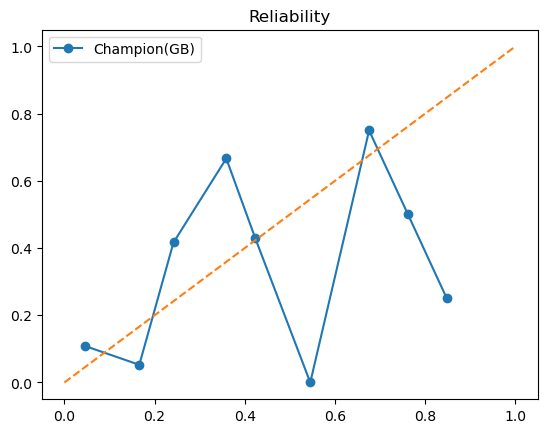


[Calibrated (sigmoid)] — Test
Accuracy: 0.7446808510638298
ROC-AUC: 0.7304292929292928
PR-AUC : 0.4237722322795834
F1 (macro): 0.4268292682926829
F1 (pos)  : 0.0
Confusion:
 [[70  2]
 [22  0]]


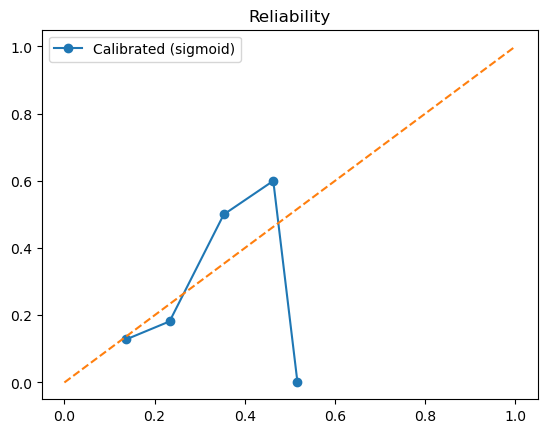


[Calibrated (isotonic)] — Test
Accuracy: 0.7659574468085106
ROC-AUC: 0.7140151515151515
PR-AUC : 0.4224114566728383
F1 (macro): 0.6050420168067226
F1 (pos)  : 0.35294117647058826
Confusion:
 [[66  6]
 [16  6]]


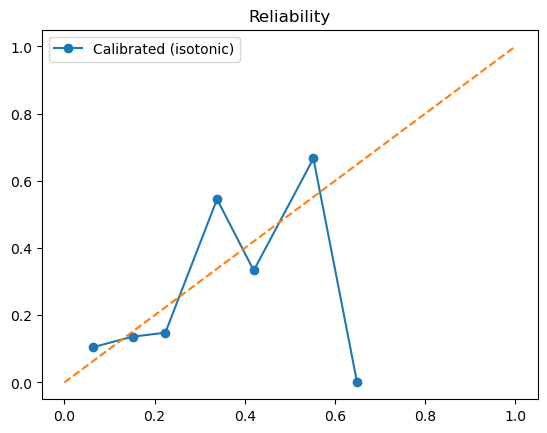


[SoftVote(RF+GB+LR)] — Test
Accuracy: 0.7659574468085106
ROC-AUC: 0.7676767676767676
PR-AUC : 0.4825176020977632
F1 (macro): 0.6736111111111112
F1 (pos)  : 0.5
Confusion:
 [[61 11]
 [11 11]]


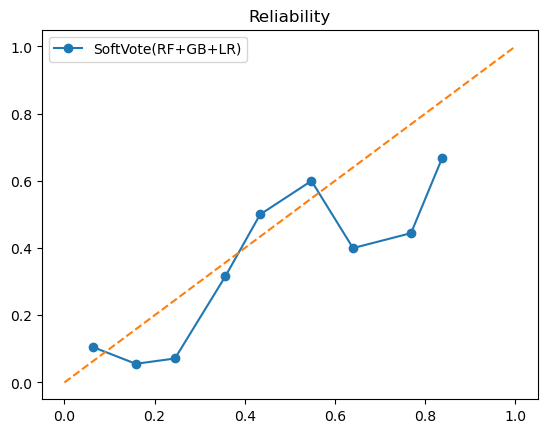

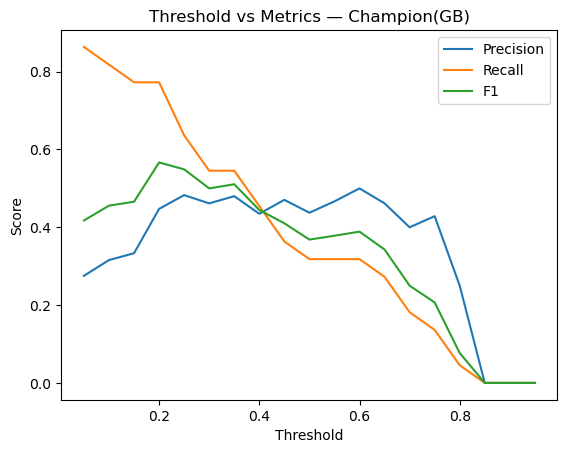

Champion(GB) — Best threshold row: {'thr': np.float64(0.2), 'prec': np.float64(0.4473684210526316), 'rec': np.float64(0.7727272727272727), 'f1': np.float64(0.5666666666666667)}


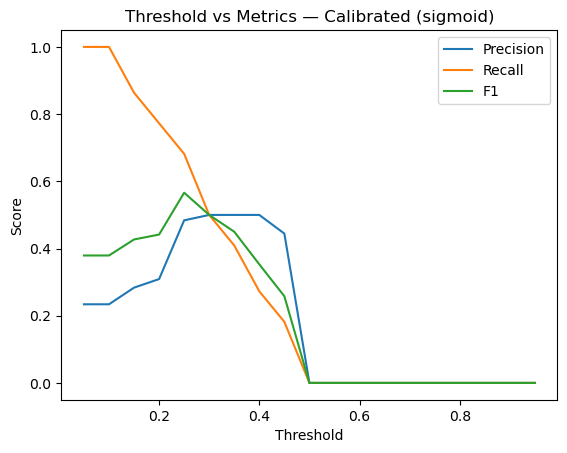

Calibrated (sigmoid) — Best threshold row: {'thr': np.float64(0.25), 'prec': np.float64(0.4838709677419355), 'rec': np.float64(0.6818181818181818), 'f1': np.float64(0.5660377358490566)}


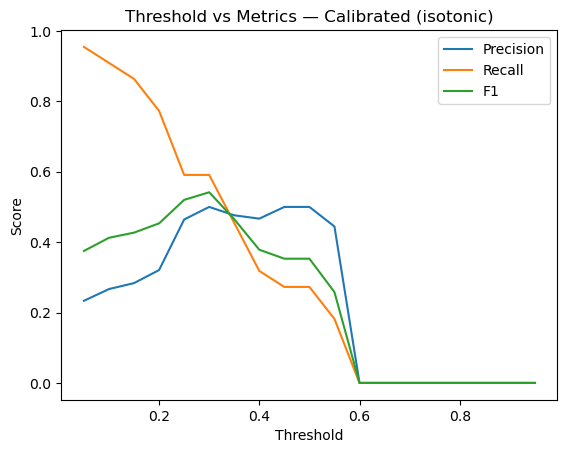

Calibrated (isotonic) — Best threshold row: {'thr': np.float64(0.3), 'prec': np.float64(0.5), 'rec': np.float64(0.5909090909090909), 'f1': np.float64(0.5416666666666666)}


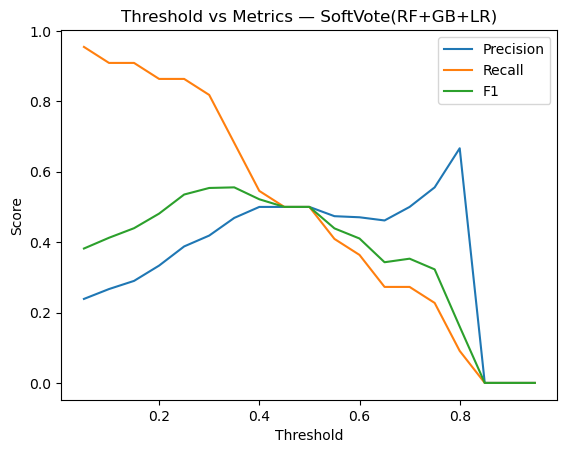

SoftVote(RF+GB+LR) — Best threshold row: {'thr': np.float64(0.35), 'prec': np.float64(0.46875), 'rec': np.float64(0.6818181818181818), 'f1': np.float64(0.5555555555555556)}

BEST: Champion(GB) | thr= 0.2 | prec= 0.4473684210526316 | rec= 0.7727272727272727 | f1= 0.5666666666666667


In [15]:

candidates = {}

if not is_tf:
    base_proba, y_bin, pos_label = metrics_sklearn(champion, X_test, y_test, label=f"Champion({champ_name})", reliability=True)
    candidates[f"Champion({champ_name})"] = (base_proba, y_bin, pos_label)
    if cal_sigmoid is not None:
        p_sig, yb_s, pl_s = metrics_sklearn(cal_sigmoid, X_test, y_test, label="Calibrated (sigmoid)", reliability=True)
        candidates["Calibrated (sigmoid)"] = (p_sig, yb_s, pl_s)
    if cal_isotonic is not None:
        p_iso, yb_i, pl_i = metrics_sklearn(cal_isotonic, X_test, y_test, label="Calibrated (isotonic)", reliability=True)
        candidates["Calibrated (isotonic)"] = (p_iso, yb_i, pl_i)

    voter = VotingClassifier(estimators=[('rf', rf), ('gb', gb), ('lr', lr)], voting='soft')
    voter.fit(X_train, y_train)
    pv, yb_v, pl_v = metrics_sklearn(voter, X_test, y_test, label="SoftVote(RF+GB+LR)", reliability=True)
    candidates["SoftVote(RF+GB+LR)"] = (pv, yb_v, pl_v)
else:
    feat = tf_results["feat"]; pre_tf = tf_results["pre"]; le_tf = tf_results["le"]; model = tf_results["model"]
    pos_idx = positive_index(list(le_tf.classes_))
    Xte_pp = pre_tf.transform(feat.transform(X_test))
    proba = model.predict(Xte_pp)[:, pos_idx]
    y_true_idx = le_tf.transform(y_test.astype(str))
    y_bin = (y_true_idx == pos_idx).astype(int)
    # reliability
    prob_true, prob_pred = calibration_curve(y_bin, proba, n_bins=10)
    plt.figure(); plt.plot(prob_pred, prob_true, marker="o", label="TF Champion")
    plt.plot([0,1], [0,1], "--"); plt.title("Reliability"); plt.legend(); plt.show()
    candidates["TF Champion"] = (proba, y_bin, str(le_tf.classes_[pos_idx]))

best_overall = None
for name, (proba, yb, pl) in candidates.items():
    df_thr = threshold_sweep(yb, proba)
    plot_threshold_curves(df_thr, label=name)
    best = df_thr.loc[df_thr["f1"].idxmax()]
    print(f"{name} — Best threshold row:", dict(best))
    if best_overall is None or best["f1"] > best_overall[1]["f1"]:
        best_overall = (name, best, df_thr)

print("\nBEST:", best_overall[0], "| thr=", float(best_overall[1]["thr"]),
      "| prec=", float(best_overall[1]["prec"]), "| rec=", float(best_overall[1]["rec"]),
      "| f1=", float(best_overall[1]["f1"]))


,feature,importance_mean
0,Recency,0.094818
1,Frequency,0.071080
3,Time,-0.006893
2,Monetary,-0.012504


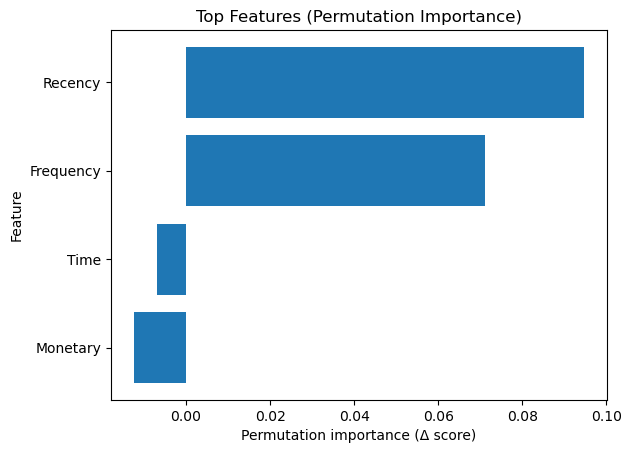

In [16]:

if not is_tf:
    explainer_model = cal_isotonic or cal_sigmoid or champion
else:
    class TFSkEstimator:
        def __init__(self, model, feat, pre, classes):
            self.model, self.feat, self.pre, self.classes_ = model, feat, pre, np.array(classes)
        def fit(self, X, y): return self
        def predict(self, X):
            P = self.predict_proba(X)
            idx = np.argmax(P, axis=1)
            return np.array([self.classes_[i] for i in idx])
        def predict_proba(self, X):
            Xp = self.pre.transform(self.feat.transform(X))
            return self.model.predict(Xp)
    explainer_model = TFSkEstimator(tf_results["model"], tf_results["feat"], tf_results["pre"], tf_results["le"].classes_)

perm = permutation_importance(explainer_model, X_test, y_test, n_repeats=10, random_state=42, scoring="f1_macro")
imp = pd.DataFrame({"feature": X_test.columns, "importance_mean": perm.importances_mean}).sort_values("importance_mean", ascending=False).head(12)
display(imp)

plt.figure(); plt.barh(imp["feature"], imp["importance_mean"])
plt.xlabel("Permutation importance (Δ score)"); plt.ylabel("Feature")
plt.title("Top Features (Permutation Importance)"); plt.gca().invert_yaxis(); plt.show()


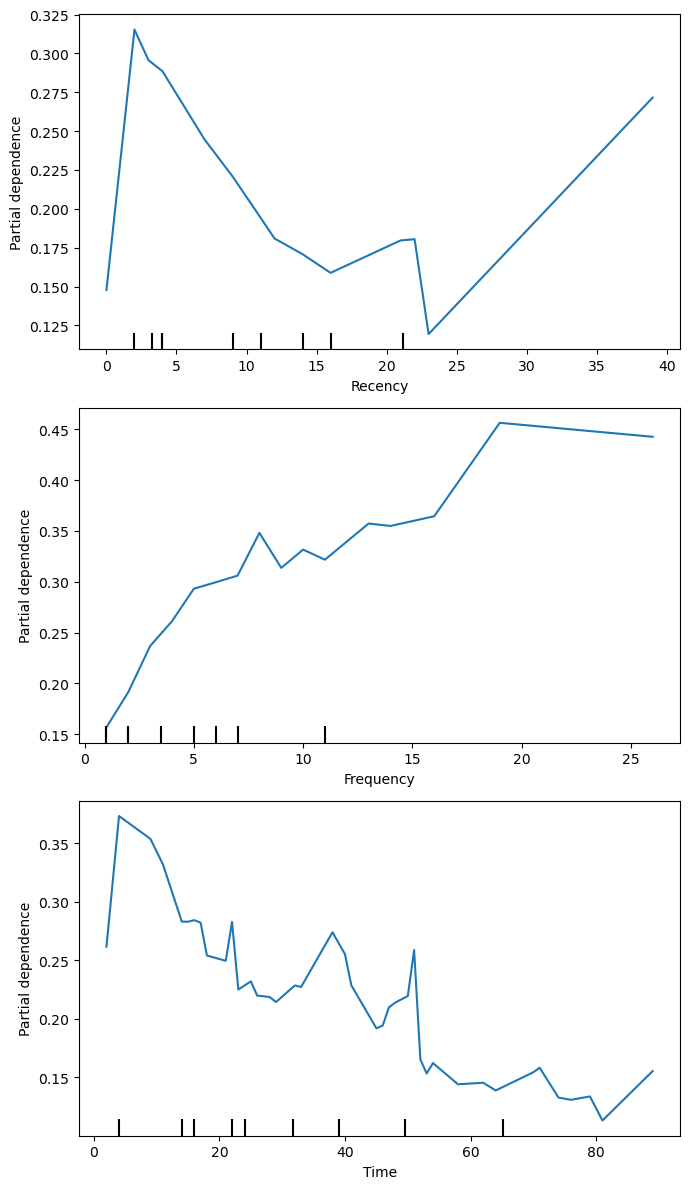

In [17]:

def custom_pdp(estimator, X_ref, feature, n_points=25, qlow=5, qhigh=95):
    x = X_ref[feature].astype(float)
    lo = np.nanpercentile(x, qlow); hi = np.nanpercentile(x, qhigh)
    grid = np.linspace(lo, hi, n_points)
    means = []
    for v in grid:
        X_mod = X_ref.copy(); X_mod[feature] = v
        proba = estimator.predict_proba(X_mod)
        if proba.ndim == 1: proba = proba.reshape(-1,1)
        if proba.shape[1] == 2: means.append(float(np.nanmean(proba[:,1])))
        else: means.append(float(np.nanmean(proba.max(axis=1))))
    plt.figure(); plt.plot(grid, means)
    plt.xlabel(feature); plt.ylabel("Avg predicted probability")
    plt.title(f"Partial Dependence (custom) — {feature}"); plt.show()

num_cols = X_test.select_dtypes(include=[np.number]).columns.tolist()
top_num = [f for f in imp["feature"].tolist() if f in num_cols][:3]

try:
    from sklearn.inspection import PartialDependenceDisplay
    fig, ax = plt.subplots(len(top_num), 1, figsize=(7, 4*len(top_num)))
    if len(top_num)==1: ax = [ax]
    for i, ftr in enumerate(top_num):
        PartialDependenceDisplay.from_estimator(explainer_model, X_test, [ftr], ax=ax[i], kind="average")
    plt.tight_layout(); plt.show()
except Exception as e:
    print("sklearn PDP failed (fallback to custom):", e)
    for ftr in top_num:
        custom_pdp(explainer_model, X_test, ftr)


In [18]:

OUT_DIR = "blood_prod_artifacts"
os.makedirs(OUT_DIR, exist_ok=True)
best_name = best_overall[0]
best_threshold = float(best_overall[1]["thr"])

if not is_tf:
    name_to_model = {
        f"Champion({champ_name})": champion,
        "Calibrated (sigmoid)": cal_sigmoid,
        "Calibrated (isotonic)": cal_isotonic,
        "SoftVote(RF+GB+LR)": VotingClassifier(estimators=[('rf', rf), ('gb', gb), ('lr', lr)], voting='soft').fit(X_train, y_train)
    }
    best_model = name_to_model.get(best_name, champion)
    joblib.dump(best_model, os.path.join(OUT_DIR, "model.joblib"))
    meta_classes = list(best_model.classes_)
else:
    tf_results["model"].save(os.path.join(OUT_DIR, "tf_tabular_model.keras"))
    joblib.dump(tf_results["feat"], os.path.join(OUT_DIR, "feature_adder.joblib"))
    joblib.dump(tf_results["pre"], os.path.join(OUT_DIR, "preprocessor.joblib"))
    joblib.dump(tf_results["le"], os.path.join(OUT_DIR, "label_encoder.joblib"))
    meta_classes = list(tf_results["le"].classes_)

joblib.dump(best_threshold, os.path.join(OUT_DIR, "threshold.joblib"))
with open(os.path.join(OUT_DIR, "model_card.json"), "w") as f:
    json.dump({
        "selected_model": best_name,
        "threshold": best_threshold,
        "classes": meta_classes,
        "target_col": target_col
    }, f, indent=2)

print("Saved artifacts to:", OUT_DIR)


Saved artifacts to: blood_prod_artifacts
